In [1]:
# Importation des modules

import pandas as pd
from gensim.models import Word2Vec
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

#Affichage de toutes les colonnes

pd.set_option('display.max_columns', 500)

In [2]:
def moyenne(L):
    s = 0
    for i in L:
        if str(i) == 'inf':
            pass
        else:
            s += i
        
    return s/len(L)

In [7]:
w2v_model_novice = Word2Vec.load("results/word2vec_novice_300.model")

w2v_model_exp = Word2Vec.load("results/word2vec_exp_300.model")

w2v_model_all = Word2Vec.load("results/word2vec_all_300.model")

In [8]:
words_novice = list(w2v_model_novice.wv.vocab.keys())
words_exp = list(w2v_model_exp.wv.vocab.keys())
words_all = list(w2v_model_all.wv.vocab.keys())

In [9]:
#v = w2v_model_novice.wv.get_vector('ministre') + w2v_model_novice.wv.get_vector('santé')
#w2v_model_novice.similar_by_vector(v, topn=10, restrict_vocab=None)

In [14]:
w2v_model_all.wv.most_similar(positive=["macron_Exp"])

[('emmanuel_Exp_macron_Exp', 0.6134518384933472),
 ('président_Exp_république_Exp', 0.4813357889652252),
 ('président_Exp_macron_Exp', 0.44401416182518005),
 ('candidat_Exp_macron_Exp', 0.42311200499534607),
 ('françois_Exp_hollande_Exp', 0.4227893352508545),
 ('nicolas_Exp_sarkozy_Exp', 0.37940847873687744),
 ('hollande_Exp', 0.36969682574272156),
 ('présidentielle_Exp', 0.36339643597602844),
 ('époque_Exp', 0.3598662316799164),
 ('sarkozy_Exp', 0.3554207980632782)]

### Overlap et spread

#### Overlap

In [4]:
def overlap(model1, model2, n, word):

    neighborhood_1 = set([i[0] for i in model1.wv.most_similar(positive=[word], topn = n)])
    neighborhood_2 = set([i[0] for i in model2.wv.most_similar(positive=[word], topn = n)])

    return len(neighborhood_1.intersection(neighborhood_2))

In [5]:
words_common = list(set(words_exp).intersection(set(words_novice)))
random.shuffle(words_common)

/Users/lilian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lilian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


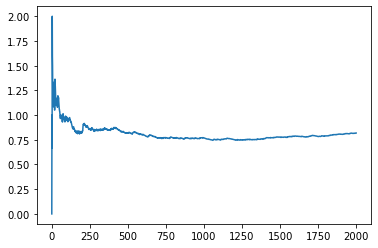

In [6]:
# Overlap avec une profondeur de 10 mots

L_10 = [overlap(w2v_model_novice, w2v_model_exp, 10, word) for word in words_common[:2000]]
plt.plot([np.mean(L_10[:i]) for i in range(2000)])

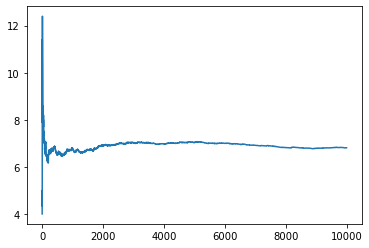

In [7]:
# Overlap avec une profondeur de 100 mots


L_100 = [overlap(w2v_model_novice, w2v_model_exp, 100, word) for word in words_common[:10000]]
plt.plot([np.mean(L_100[:i]) for i in range(10000)])

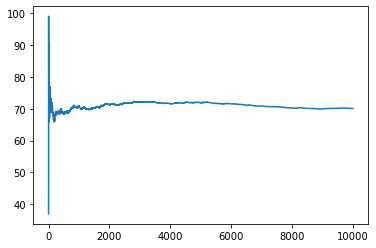

In [8]:
# Overlap avec une profondeur de 1000 mots

L_1000 = [overlap(w2v_model_novice, w2v_model_exp, 1000, word) for word in words_common[:10000]]
plt.plot([np.mean(L_1000[:i]) for i in range(10000)])

#### Spread

In [9]:
def rank(model, i, j):
    
    k = -1
    K = 10
    
    while k == -1 and 10 * K < len(words_exp):
        neighborhood = [i[0] for i in model.wv.most_similar(positive=[i], topn = K)]
        try:
            k = neighborhood.index(j)
        except:
            k = -1
        K *= 10
            
    return k + 1

def spread(model1, model2, n, word):

    neighborhood_1 = [i[0] for i in model1.wv.most_similar(positive=[word], topn = n)]
    ranks = [rank(model2, word, j) for j in neighborhood_1]
    return max(ranks)

In [10]:
#print(w2v_model_exp.wv.most_similar(positive=['droite'], topn = 10))
#rank(w2v_model_exp, 'droite', 'sarkozysme')

In [11]:
spread(w2v_model_novice, w2v_model_exp, 10, 'droite')

831

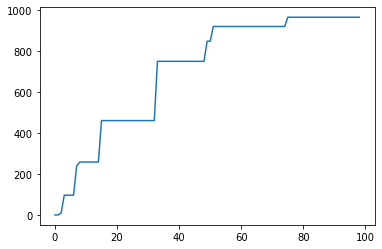

In [12]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, i, 'demain') for i in range(1,100)])

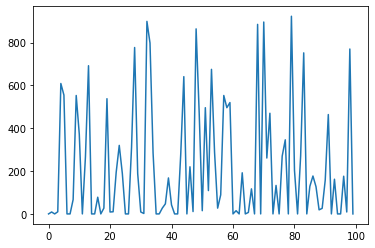

In [13]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, 6, word) for word in words_common[:100]])

## WMD 

In [15]:
# Normalisation des vecteurs

w2v_model_exp.init_sims(replace = True)
w2v_model_novice.init_sims(replace = True)
w2v_model_all.init_sims(replace = True)

In [16]:
df0 = pd.read_csv('data/data_cleaned_NLP.csv', sep = ',', encoding = 'latin-1')

In [17]:
df1 = df0[['Réplique', 'Groupe', 'tokenized_replique', 'Orateur']].copy()

df_novice = df1[df1['Groupe'] == 'Novice'].copy()
df_exp = df1[df1['Groupe'] == 'Exp'].copy()

In [18]:
df_novice = df_novice.dropna()

df_exp = df_exp.dropna()

In [19]:
phrase0 = df_novice.iloc[0]['tokenized_replique'].split(' ')
phrase1 = df_novice.iloc[1]['tokenized_replique'].split(' ')
phrase2 = df_novice.iloc[2]['tokenized_replique'].split(' ')

### Calcul des distances intra

#### Novices

##### Distance selon le modèle Novice

In [26]:
df_novice_shuffled = df_novice.sample(frac=1)
phrases_novice = [df_novice_shuffled.iloc[i]['tokenized_replique'].split(' ') for i in range(2 * 10000)]

In [27]:
WMD_novices = [w2v_model_novice.wv.wmdistance(phrases_novice[i], phrases_novice[i + 1]) for i in range(0, 20000, 2)]

In [28]:
means_novice = [moyenne(WMD_novices[:i]) for i in range(1, 10000)]

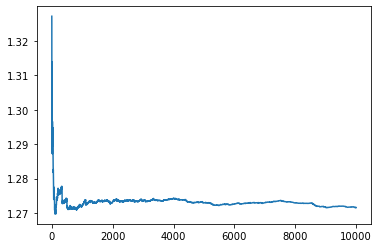

In [30]:
plt.plot([i for i in range(1, 10000)], means_novice)

In [31]:
distance_intra_novice = np.mean(means_novice[9000:10000])
print(distance_intra_novice)

1.271815796406192


##### Distance selon le modèle Exp


In [35]:
WMD_novices_expmodel = [w2v_model_exp.wv.wmdistance(phrases_novice[i], phrases_novice[i + 1]) for i in range(0, 20000, 2)]

In [36]:
means_novice_expmodel = [moyenne(WMD_novices_expmodel[:i]) for i in range(1, 10000)]

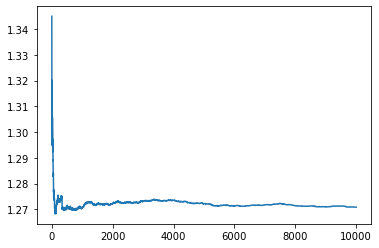

In [37]:
plt.plot([i for i in range(1, 10000)], means_novice_expmodel)

In [38]:
distance_intra_novice_expmodel = np.mean(means_novice_expmodel[9000:10000])
print(distance_intra_novice_expmodel)

1.2710743646672007


##### Distance selon le modèle All

In [44]:
def add_groupe(L, etiquette):
    return [i + etiquette for i in L]

In [46]:
WMD_novices_allmodel = [
    w2v_model_all.wv.wmdistance(
            add_groupe(phrases_novice[i], '_Novice'), 
            add_groupe(phrases_novice[i + 1], '_Novice')) 
    for i in range(0, 20000, 2)
                        ]

In [47]:
means_novice_allmodel = [moyenne(WMD_novices_allmodel[:i]) for i in range(1, 10000)]

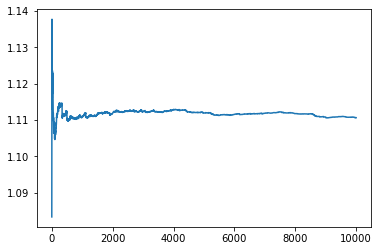

In [48]:
plt.plot([i for i in range(1, 10000)], means_novice_allmodel)

In [49]:
distance_intra_novice_allmodel = np.mean(means_novice_allmodel[9000:10000])
print(distance_intra_novice_allmodel)

1.110758590539561


#### Non-novices

##### Distance selon le modèle Exp

In [50]:
df_exp_shuffled = df_exp.sample(frac = 1)
phrases_exp = [df_exp_shuffled.iloc[i]['tokenized_replique'].split(' ') for i in range(2 * 10000)]

In [51]:
WMD_exp = [w2v_model_exp.wv.wmdistance(phrases_exp[i], phrases_exp[i + 1]) for i in range(0, 20000, 2)]

In [52]:
means_exp = [moyenne(WMD_exp[:i]) for i in range(1, 10000)]

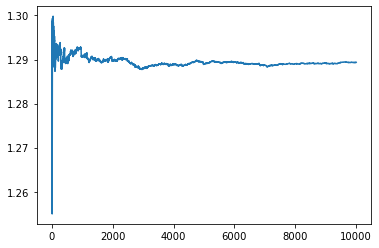

In [53]:
plt.plot([i for i in range(1, 10000)], means_exp)

In [54]:
distance_intra_exp = np.mean(means_exp[9000:10000])
print(distance_intra_exp)

1.2892407324774735


##### Distance selon le modèle Novice

In [55]:
WMD_exp_novicemodel = [w2v_model_novice.wv.wmdistance(phrases_exp[i], phrases_exp[i + 1]) for i in range(0, 20000, 2)]

In [56]:
means_exp_novicemodel = [moyenne(WMD_exp_novicemodel[:i]) for i in range(1, 10000)]

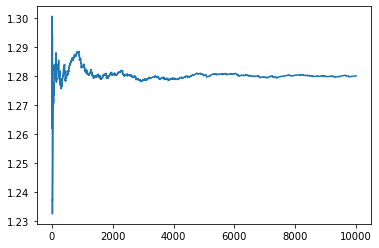

In [57]:
plt.plot([i for i in range(1, 10000)], means_exp_novicemodel)

In [58]:
distance_intra_exp_novicemodel = np.mean(means_exp_novicemodel[9000:10000])
print(distance_intra_exp_novicemodel)

1.2799021841122362


##### Distance selon le modèle All

In [59]:
WMD_exp_allmodel = [
    w2v_model_all.wv.wmdistance(
            add_groupe(phrases_exp[i], '_Exp'), 
            add_groupe(phrases_exp[i + 1], '_Exp')) 
    for i in range(0, 20000, 2)
                        ]

In [60]:
means_exp_allmodel = [moyenne(WMD_exp_allmodel[:i]) for i in range(1, 10000)]

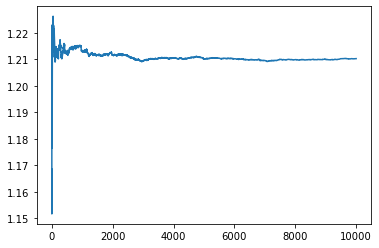

In [61]:
plt.plot([i for i in range(1, 10000)], means_exp_allmodel)

In [62]:
distance_intra_exp_allmodel = np.mean(means_exp_allmodel[9000:10000])
print(distance_intra_exp_allmodel)

1.2100759609137652


### Distances inter

In [63]:
WMD_inter_model_exp = [w2v_model_exp.wmdistance(phrases_exp[i], phrases_novice[i]) for i in range(0, 600)]
WMD_inter_model_novice = [w2v_model_novice.wmdistance(phrases_exp[i], phrases_novice[i]) for i in range(0, 600)]
WMD_inter_model_all = [w2v_model_all.wmdistance(
                                        add_groupe(phrases_exp[i], '_Exp'),
                                        add_groupe(phrases_novice[i], '_Novice'))
                                       for i in range(0, 600)]

<ipython-input-63-ee8710556f69>:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  WMD_inter_model_exp = [w2v_model_exp.wmdistance(phrases_exp[i], phrases_novice[i]) for i in range(0, 600)]
<ipython-input-63-ee8710556f69>:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  WMD_inter_model_novice = [w2v_model_novice.wmdistance(phrases_exp[i], phrases_novice[i]) for i in range(0, 600)]
<ipython-input-63-ee8710556f69>:3: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  WMD_inter_model_all = [w2v_model_all.wmdistance(


In [64]:
means_model_exp = [moyenne(WMD_inter_model_exp[:i]) for i in range(1, 600)]
means_model_novice = [moyenne(WMD_inter_model_novice[:i]) for i in range(1, 600)]
means_model_all = [moyenne(WMD_inter_model_all[:i]) for i in range(1, 600)]

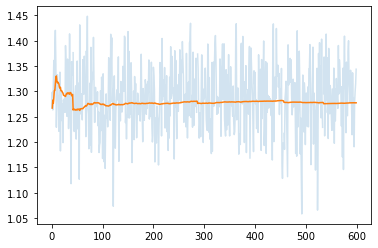

In [65]:
plt.plot([i for i in range(600)], WMD_inter_model_novice, alpha = .2)
plt.plot([i for i in range(1, 600)], means_model_novice)

In [66]:
distance_inter_novice = np.mean(means_model_novice[300:600])
print(distance_inter_novice)

1.2785903571592434


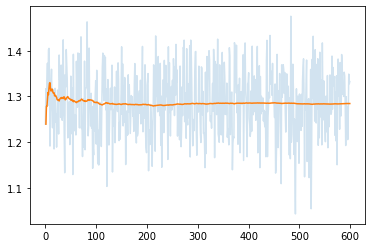

In [67]:
plt.plot([i for i in range(600)], WMD_inter_model_exp, alpha = .2)
plt.plot([i for i in range(1, 600)], means_model_exp)

In [68]:
distance_inter_exp = np.mean(means_model_exp[300:500])
print(distance_inter_exp)

1.285006760375744


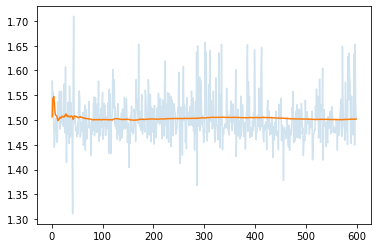

In [69]:
plt.plot([i for i in range(600)], WMD_inter_model_all, alpha = .2)
plt.plot([i for i in range(1, 600)], means_model_all)

In [70]:
distance_inter_all = np.mean(means_model_exp[300:500])
print(distance_inter_exp)

1.285006760375744


### Résumé WMD

In [77]:
scores = [distance_intra_novice, distance_intra_exp_novicemodel, distance_inter_novice,
          distance_intra_novice_expmodel, distance_intra_exp, distance_inter_exp,
          distance_intra_novice_allmodel, distance_intra_exp_allmodel, distance_inter_all]

In [78]:
px.histogram(x = ['Intra novice, modèle Novice', 'Intra Exp, modèle Novice', 'Inter, modèle novice',
                  'Intra Novice, modèle Exp', 'Intra Exp, modèle Exp', 'Inter, modèle Exp',
                  'Intra Novice, modèle All', 'Intra Exp, modèle All', 'Inter, modèle All'
                   ], 
             y = scores,
             range_y = [0.995 * min(scores), 1.005 * max(scores)])